# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [7]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

#sys.path.append("/home/laraib/PycharmProjects/untitled2/venv/models-master/research/")
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [ ]:
import io
from google.cloud import vision_v1p3beta1 as vision
from datetime import datetime
import cv2
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [10]:
#sys.path.append("/home/laraib/PycharmProjects/untitled2/venv/models-master/research/object_detection")
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

In [11]:
# Setup google authen client key
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/client_key.json'

# Source path content all images
SOURCE_PATH = "/home/laraib/Music/test/numberplate/"


## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [12]:
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

PATH_TO_LABELS = os.path.join('data', 'traffic_label.pbtxt')

## Download Model

In [13]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [14]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [15]:
def recognize_license_plate(img_path):

    start_time = datetime.now()

    # Read image with opencv
    img = cv2.imread(img_path)

    # Get image size
    height, width = img.shape[:2]

    #crp_img = img[103:748,291:1300]
    #cv2.imshow("Crop", crp_img)
    # Scale image
    img = cv2.resize(img, (800, int((height * 800) / width)))

    # Show the origin image
    cv2.imshow('Origin image', img)

    # Save the image to temp file
    #cv2.imwrite(SOURCE_PATH + "output.jpg", img)

    # Create new img path for google vision

    # Create google vision client
    client = vision.ImageAnnotatorClient()

    # Read image file
    with io.open(img_path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)

    # Recognize text
    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        print(len(text.description))
        if len(text.description) >= 10:
            license_plate = text.description
            print(license_plate)
            vertices = [(vertex.x, vertex.y)
                        for vertex in text.bounding_poly.vertices]

            # Put text license plate number to image
            cv2.putText(img, license_plate, (200, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)

            print(vertices)
            # Draw rectangle around license plate
            cv2.rectangle(img, (vertices[0][0]-10, vertices[0][1]-10), (vertices[2][0]+10, vertices[2][1]+10), (0, 255, 0), 3)
            print('Total time: {}'.format(datetime.now() - start_time))
            cv2.imshow('Recognize & Draw', img)
            cv2.waitKey(0)

In [16]:
NUM_CLASSES = 601
label_map = label_map_util.load_labelmap("/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/data/traffic_label.pbtxt")
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [17]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.int64)

# Detection

In [18]:
PATH_TO_TEST_IMAGES_DIR = '/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 14) ]

IMAGE_SIZE = (12, 8)
print(TEST_IMAGE_PATHS)

['/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/test_images/image1.jpg', '/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/test_images/image2.jpg', '/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/test_images/image3.jpg', '/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/test_images/image4.jpg', '/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/test_images/image5.jpg', '/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/test_images/image6.jpg', '/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/test_images/image7.jpg', '/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object_detection/test_images/image8.jpg', '/home/laraib/PycharmProjects/TrafficTracker/venv/models-master/research/object

In [19]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int64)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.1), tf.int64)
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

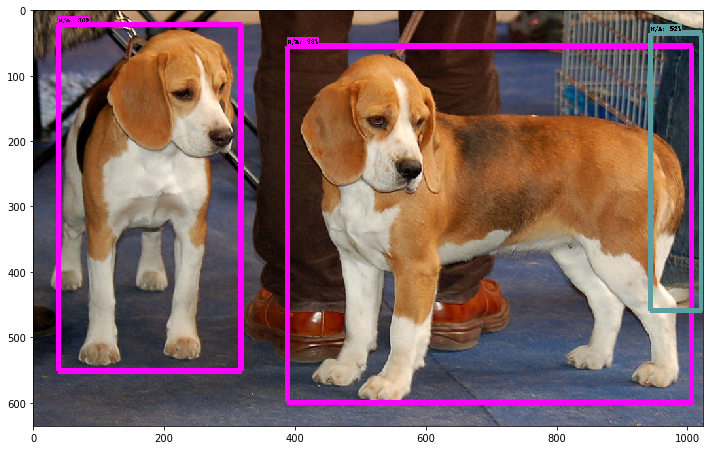

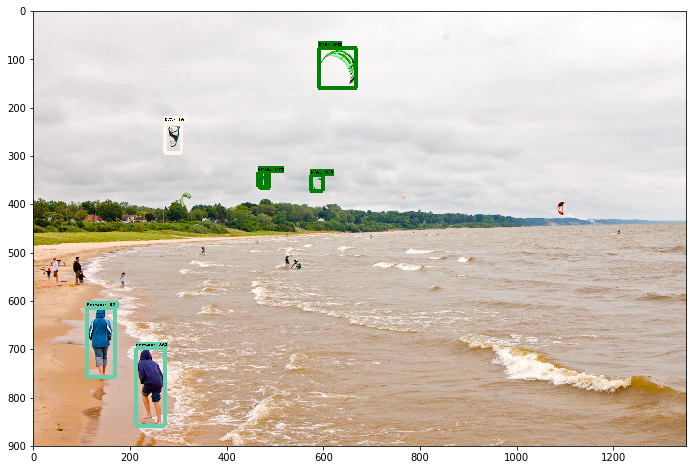

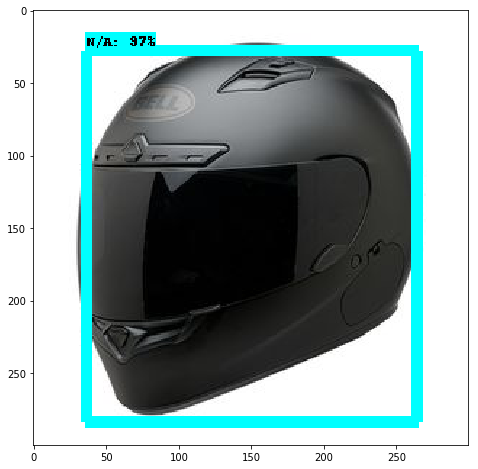

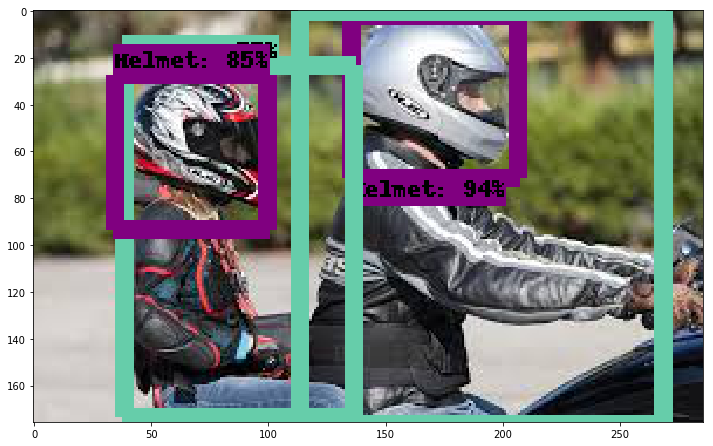

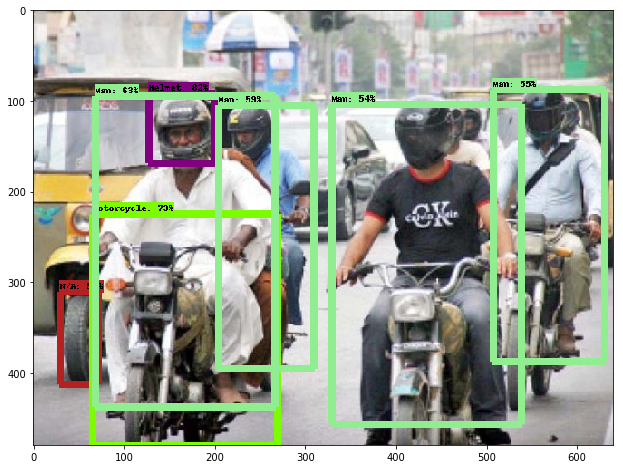

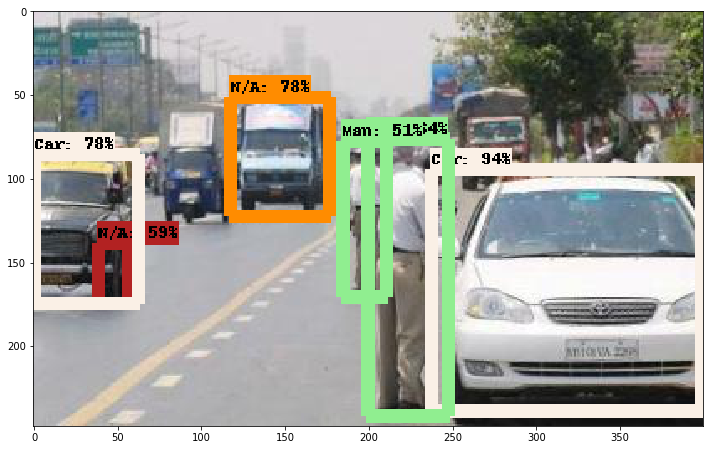

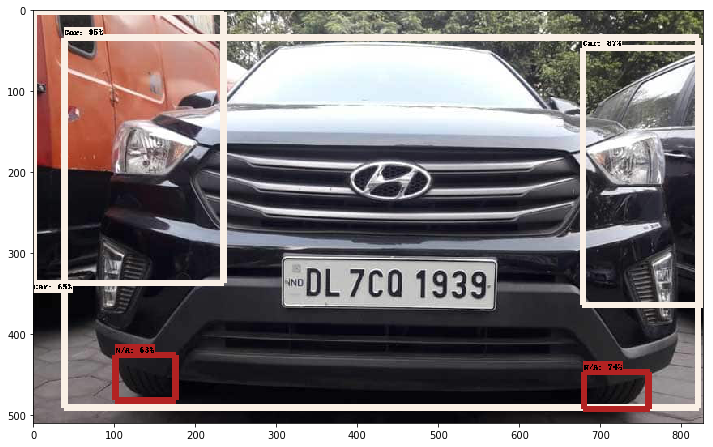

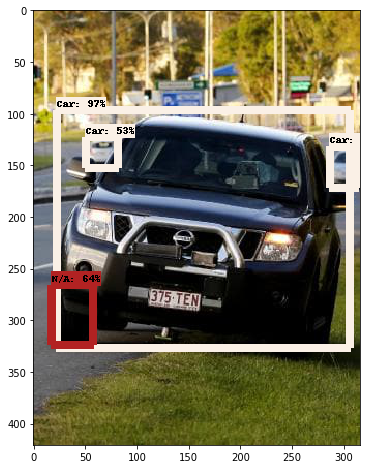

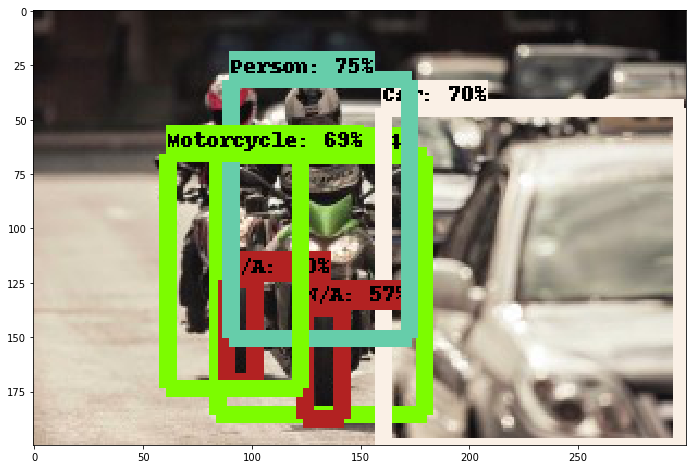

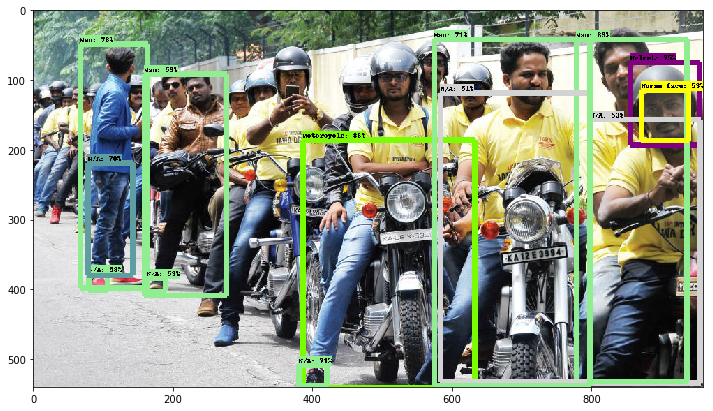

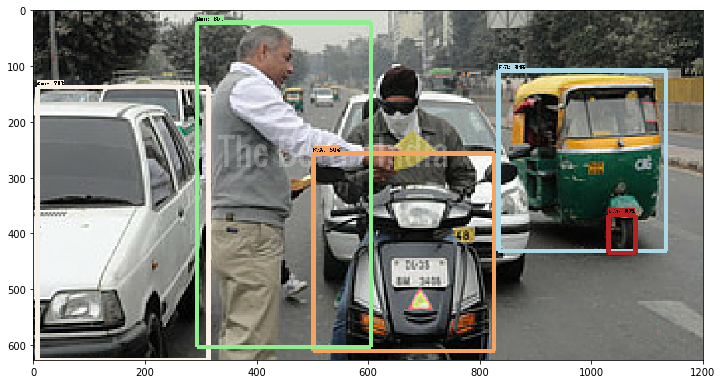

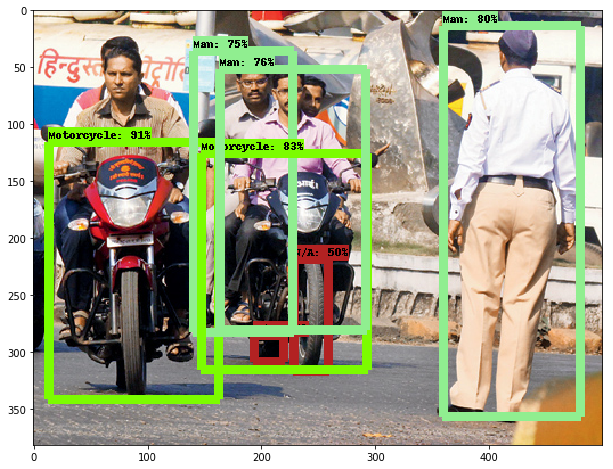

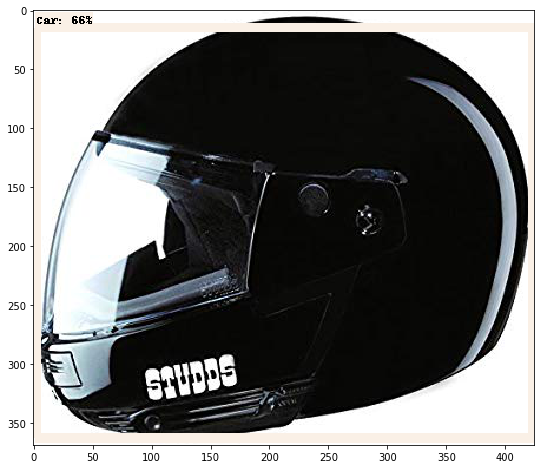

In [20]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  image_np = load_image_into_numpy_array(image)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  #recognize_license_plate(image_path)
  '''im_width, im_height = image.size
  ymin = output_dict['detection_boxes'][0][1]*im_height
  xmin = output_dict['detection_boxes'][0][0]*im_width
  ymax = output_dict['detection_boxes'][0][3]*im_height
  xmax = output_dict['detection_boxes'][0][2]*im_width
  print(xmin)
  print(xmax)
  print(ymin)
  print(ymax)'''
  
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)